## Recommender Systems 

## Collaborative Filtering (Matrix factorization, Count-based)

In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from surprise import Reader, Dataset, SVD , SVDpp
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from itertools import combinations
from collections import defaultdict
from surprise.model_selection.validation import cross_validate
from surprise import SVD, KNNBasic
from surprise import accuracy
import os
from surprise import BaselineOnly, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD
from surprise import accuracy, Dataset, SVD
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import root_mean_squared_error
from surprise.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

import os
for dirname, _, filenames in os.walk('/kaggle/input/board-games-database-from-boardgamegeek/user_ratings.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Importing dataset

In [4]:
games = pd.read_csv("/kaggle/input/board-games-database-from-boardgamegeek/games.csv")
games = games[["BGGId", "Name"]]

In [5]:
df = pd.read_csv("/kaggle/input/board-games-database-from-boardgamegeek/user_ratings.csv")

In [6]:
df.head()

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


### Encoding Usernames

In [7]:
label_encoder = LabelEncoder()
df['userId'] = label_encoder.fit_transform(df['Username'])

In [8]:
df = df.drop(columns=["Username"])

In [9]:
cols = df.columns.tolist()
cols[0], cols[2] = cols[2], cols[0]
df = df[cols]

In [10]:
cols = df.columns.tolist()
cols[1], cols[2] = cols[2], cols[1]
df = df[cols]

### Rating Distribution

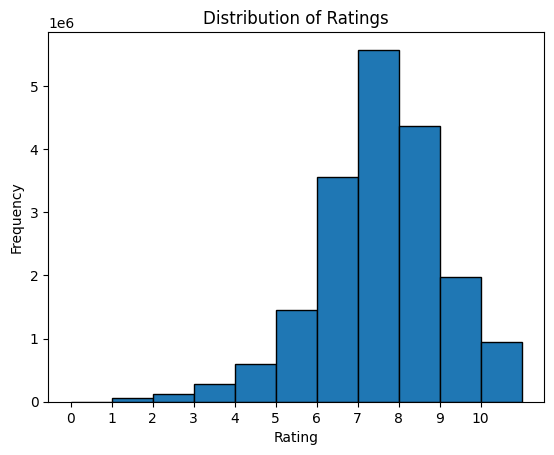

In [11]:
plt.hist(df['Rating'], bins=range(int(df['Rating'].min()), int(df['Rating'].max()) + 2), edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.xticks(range(int(df['Rating'].min()) , int(df['Rating'].max()) + 1))
plt.grid(False)
plt.show()

### SVD - Matrix Factorization

### Now I will use the Surpise library for the SVD analysis since the dataset was large and classic SVD using matrix needed excess computational power

In [12]:
min_rating = df['Rating'].min()
max_rating = df['Rating'].max()

print("Minimum Rating:", min_rating)
print("Maximum Rating:", max_rating)

Minimum Rating: 0.0001
Maximum Rating: 10.0


In [13]:
# Load Reader library
reader = Reader(rating_scale=(min_rating, max_rating))

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(df[['userId', 'BGGId', 'Rating']], reader)

### Cross Validation

In [18]:
# Use the SVD algorithm.
svd = SVD(n_factors=100, n_epochs=20,random_state = 123,verbose = True , lr_all = 0.01)
svdpp = SVDpp(n_factors=100, n_epochs=20,random_state = 123,verbose = True, lr_all = 0.01)

subset_df = df.sample(frac=0.1, random_state=42)
val_data = Dataset.load_from_df(subset_df[['userId', 'BGGId', 'Rating']], reader)

# # Compute the RMSE of the SVD algorithm.
cross_validate(svd, val_data, measures=['RMSE'],cv=5,verbose=True)
cross_validate(svdpp, val_data, measures=['RMSE'],cv=5,verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'test_rmse': array([1.29836092, 1.29522551, 1.29617927, 1.29641252, 1.29989882]),
 'fit_time': (701.8148283958435,
  698.989349603653,
  698.6185834407806,
  702.5575323104858,
  697.2489113807678),
 'test_time': (28.14454460144043,
  27.920510053634644,
  28.098821878433228,
  27.87234330177307,
  28.016515493392944)}

### As we can see from the results of cross validation, the SVD seem to has better RMSE score so I will try this model from the predictions.
### SVD train test split, fit, check RMSE

In [20]:
trainset, testset = train_test_split(data, test_size=0.2)

In [21]:
svd = SVD(n_factors=100, n_epochs=20,verbose = True)
svd.fit(trainset)
predictions_svd_total = svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [23]:
accuracy.rmse(predictions_svd_total)

RMSE: 1.2121


1.2120721922383484

### The following is for the actual recommendations per user and a check of RMSE for 

In [25]:
def recommend_surprise(uid:int,
              ratings_df:pd.core.frame.DataFrame,
              model,
              movies_df:np.ndarray,
              rec_num:int
             ):

    #get all the ratings by this user
    my_ratings=ratings_df[ratings_df.userId==uid]

    #zip the ratings into a dict
    already_rated=dict(zip(my_ratings.BGGId,my_ratings.Rating))

    pred_dict={}# store predicted ratings

    for index,row in movies_df.iterrows(): # for every movie 

        pred_dict[row.BGGId]=svd.predict(uid=uid,iid= row.BGGId).est# get the pred for this user
        
    # sort the movies by predicted ratings
    srt=sorted(pred_dict.items(),key=lambda x:x[1],reverse=True)
    
    rec_set=set()# set of movie ids to be recommended
    
    for mid,pred in srt: # for each movie id 
        if mid not in already_rated: # movie has not already been rated
            
            rec_set.add(mid) # add to the set
            
            if len(rec_set)==rec_num:break 
       
    # make a data frame with only the recommended movies 
    rec_df=pd.DataFrame(movies_df[movies_df.BGGId.isin(rec_set)])
    
    #add the predicted rating as a new column
    rec_df['predicted_rating']=rec_df['BGGId'].map(pred_dict)
    
    #sort the df by the new col
    rec_df=rec_df.sort_values(['predicted_rating'], ascending=False)

    return rec_df

In [38]:
def validate(uid:int,
              ratings_df:pd.core.frame.DataFrame,
              model,
              movies_df:np.ndarray
             ):

    #get all the ratings by this user
    my_ratings=ratings_df[ratings_df.userId==uid]

    #zip the ratings into a dict
    already_rated=dict(zip(my_ratings.BGGId,my_ratings.Rating))

    pred_dict={}# store predicted ratings

    for index,row in movies_df.iterrows(): # for every movie 

        pred_dict[row.BGGId]=svd.predict(uid=uid,iid= row.BGGId).est# get the pred for this user
        
    actual,pred=[],[]
    for mid in already_rated: # for each movie id 
        actual.append(already_rated[mid])
        pred.append(pred_dict[mid])
    
    return np.sqrt(mean_squared_error(actual,pred,squared=False))

In [39]:
recommend_surprise(1,df,svd,games,10)

,BGGId,Name,predicted_rating
9398,55690,Kingdom Death: Monster,9.962101
18560,246900,Eclipse: Second Dawn for the Galaxy,9.527105
20366,284121,Uprising: Curse of the Last Emperor,9.521973
21896,342942,Ark Nova,9.517983
21915,345976,System Gateway (fan expansion for Android: Net...,9.472361
14901,180263,The 7th Continent,9.431222
17834,233078,Twilight Imperium: Fourth Edition,9.418143
14509,174430,Gloomhaven,9.378212
20830,295785,Euthia: Torment of Resurrection,9.369342
17329,224517,Brass: Birmingham,9.360065


In [47]:
print("The RMSE of the predictions for the user 1: ",validate(1,df,svd,games))

The RMSE of the predictions for the user 1:  0.7457465417678942


### Try Baseline and KNN

### Need to keep a part of the dataset and will not do it randomly but I will keep those with more the 1000 ratings so there will be patterns in the dataset for the algorythm to recognise

In [48]:
least_ratings = 1000
rating_counts = df['userId'].value_counts()
users_with_least_ratings = rating_counts[rating_counts >= least_ratings].index
df = df[df['userId'].isin(users_with_least_ratings)]

In [50]:
df.head()

,userId,BGGId,Rating
18,260509,213788,7.5
29,382190,213788,7.0
57,159361,213788,6.5
70,140274,213788,5.0
72,287225,213788,4.0


In [51]:
df = df.reset_index(drop=True)

In [52]:
min_rating = df['Rating'].min()
max_rating = df['Rating'].max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df[['userId', 'BGGId', 'Rating']], reader)

In [53]:
trainset, testset = train_test_split(data, test_size=0.2)

In [54]:
baseline = BaselineOnly()
baseline.fit(trainset)
predictions_baseline = baseline.test(testset)
svd = SVD()
svd.fit(trainset)
predictions_svd = svd.test(testset)
knn = KNNBasic()
knn.fit(trainset)
predictions_knn = knn.test(testset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [57]:
rmse_baseline = accuracy.rmse(predictions_baseline)
rmse_svd = accuracy.rmse(predictions_svd)
rmse_knn = accuracy.rmse(predictions_knn)
print("\nRMSE for Baseline:", rmse_baseline)
print("RMSE for SVD:", rmse_svd)
print("RMSE for KNN:", rmse_knn)

RMSE: 1.1988
RMSE: 1.1955
RMSE: 1.2925

RMSE for Baseline: 1.1988145875643812
RMSE for SVD: 1.1955118780123886
RMSE for KNN: 1.2924805326379285


### Count Based algorythm

### I used the given algorythm from the first lecture with few changes

In [58]:
def load_user_ratings(ratings_df:pd.core.frame.DataFrame):
    
    '''
    Loads all the ratings submitted by each user
    
    Returns a dictionary that maps each user to a second dict that maps movies to discretized ratings
    
    '''
    
    distinct_users=set(ratings_df['userId']) # get all distinct users
    
    user_ratings={} # store movie ratings per user 
    
    for user in distinct_users: # for each user

        # get the movie id and rating for every rating submitted by this user
        my_ratings=df[df.userId==user][['BGGId','Rating']] 

        #discretize the ratings and attach them to the user
        user_ratings[user]=dict(zip(my_ratings.BGGId, my_ratings.Rating))
    return user_ratings

In [59]:
user_ratings=load_user_ratings(df)

In [60]:
# first_element = list(user_ratings.items())[1]

In [61]:
# first_element[0]

In [62]:
def get_user_neighbors(user_ratings:dict, # ratings submitted by each user
                       min_rating_num:int=least_ratings # at least this many ratings are required for a comparison
                      ):
    
    '''
    Compute rating-based similarity between every two pairs of users 
    
    '''
    
    #get all possible pairs of usres
    pairs=list(combinations(list(user_ratings.keys()),2))
    
    usim=defaultdict(dict) # initialize the sim dictionary
    
    for u1,u2 in pairs: # for every user pair 
   
        #get a set with all the discretized ratings (movie id, polarity tuples) for u1 and u2
        s1=set([(mid,pol) for mid,pol in user_ratings[u1].items()])
        s2=set([(mid,pol) for mid,pol in user_ratings[u2].items()])

        # check if both users respect the lower bound
        if len(s1)<min_rating_num or len(s2)<min_rating_num: continue
      
        # get the union and intersection for these two users
        union=s1.union(s2)
        inter=s1.intersection(s2)
    
        # compute user sim via the jaccard coeff
        jacc=len(inter)/len(union)

        # remember the sim values
        usim[u1][u2]=jacc
        usim[u2][u1]=jacc
        
    # attach each user to its neighbors, sorted by sim in descending order 
    return {user:sorted(usim[user].items(),key=lambda x:x[1], reverse=True) for user in usim}

In [64]:
neighbors_u=get_user_neighbors(user_ratings)

### For this task I decided not to go with a positive,negative classification but with the original regression so the result can be compared with the previous question's results

### Here I havent use a rule of rewarding and punishing the relusts, but i just calculate the voting * similarity_value

In [78]:
def recommend_ub(user:int, 
                 games:pd.core.frame.DataFrame, # movie info  
                 neighbors_u:dict, # neighbors dict
                 user_ratings:dict, # ratings submitted per user 
                 neighbor_num:int, # number of neighbors to consider
                 rec_num:int,# number of movies to recommend
                 print_output=True):
  
    scores_from_already_rated = []
    top_k=neighbors_u[user][:neighbor_num] # get the top k neighbors of this user
    
    votes=defaultdict(int) # count the votes per movie
    
    for neighbor,sim_val in top_k: # for each neighbor 

        for mid,pol in user_ratings[neighbor].items(): # for each movie rated by this neighbor
            votes[mid] = pol*sim_val
    # sort the movies in desc order 
    srt=sorted(votes.items(),key=lambda x:x[1], reverse=True)
    if print_output:
        print('\nI suggest the following movies because they have\nreceived positive ratings from users who tend to\nlike what you like:\n')
          
    cnt=0 # count number of recommendations made 
    
    already_rated={}
    
    for mov, score in srt: # for each movie 
        
#         title=games.loc[mov]['Name'] # get the title 
        title=games.loc[games['BGGId'] == mov, 'Name'].values[0]
        
        rat=user_ratings[user].get(mov,None) # check if the user has already rated the movie 
        
        if rat: # movie already rated 
            already_rated[title]=rat# store the rating
            scores_from_already_rated.append(rat)
            continue
     
        cnt+=1 # one more recommendation
        if print_output:
            print('\n',mov, title) # print 
    
        if cnt==rec_num:break # stop once you 've made enough recommendations
    if print_output:
        print('\n Already rated: ',already_rated)
    return scores_from_already_rated

In [79]:
first_element = list(user_ratings.items())[5]
recommend_ub(141325, games, neighbors_u, user_ratings, 10, 10,print_output = True)


I suggest the following movies because they have
received positive ratings from users who tend to
like what you like:


 154526 Payoff Pitch Baseball

 105024 Israeli Air Force Leader

 249421 Warfighter: The WWII Pacific Combat Card Game

 294652 By Stealth and Sea

 288316 Rurik: Dawn of Kiev – Kickstarter Edition

 254936 Frontier Wars

 231920 Holdfast: Tunisia 1942-43

 293925 2GM Pacific

 291066 Endure the Stars 1.5

 250291 Hold the Line: The American Civil War

 Already rated:  {'Tide of Iron: Next Wave': 9.0, 'ASG Golf': 9.0, 'Hannibal & Hamilcar': 9.0, 'Time of Legends: Joan of Arc': 10.0, 'A Song of Ice & Fire: Tabletop Miniatures Game – Stark vs Lannister Starter Set': 9.0, 'The Great War': 9.0, 'The Edge: Dawnfall': 9.0, 'Conflict of Heroes: Guadalcanal – The Pacific 1942': 9.0, 'Combat Infantry: WestFront 1944-45': 8.0, 'Hold the Line: The American Revolution': 8.0, 'Replay Baseball': 9.0, 'Operation Jubilee: Dieppe, August 1942': 8.0, 'Dunkirk: France 1940': 8.0, 'Hold

[9.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 9.0, 8.0, 8.0, 9.0]

### Here I decided to calculate the accuracy of the algorythm, by computing the average of the ratings from the games the user had already rated and the algorythm proposed to the user 

In [80]:
total_already_rated_scores = []
cn = 0

for i in range(1, len(user_ratings)):
    fe = list(user_ratings.items())[i][0]
    try:
        list_sc_already_rated = recommend_ub(fe, games, neighbors_u, user_ratings, 10, 10, print_output=False)
        total_already_rated_scores.append(list_sc_already_rated)
    except Exception as e:
        cn +=1
        continue

In [81]:
flattened_list = [item for sublist in total_already_rated_scores for item in sublist]

In [82]:
average = sum(flattened_list) / len(flattened_list)

print("Average without rule:", average)

Average without rule: 7.144535228182547


### Now lets try the exact same algorythm but I will use the rewarding - punishing method of the lecture.

In [83]:
def recommend_ub(user:int, 
                 games:pd.core.frame.DataFrame, # movie info  
                 neighbors_u:dict, # neighbors dict
                 user_ratings:dict, # ratings submitted per user 
                 neighbor_num:int, # number of neighbors to consider
                 rec_num:int,# number of movies to recommend
                 print_output=True):
  
    scores_from_already_rated = []
    top_k=neighbors_u[user][:neighbor_num] # get the top k neighbors of this user
    
    votes=defaultdict(int) # count the votes per movie
    
    for neighbor,sim_val in top_k: # for each neighbor 

        for mid,pol in user_ratings[neighbor].items(): # for each movie rated by this neighbor

            if pol>7: # positive neighbor rating
                votes[mid]+=2*sim_val
            elif pol<7: # negative 
                votes[mid]-=2*sim_val
            else: # average 
                votes[mid]-=1*sim_val
#             votes[mid] = pol*sim_val
    # sort the movies in desc order 
    srt=sorted(votes.items(),key=lambda x:x[1], reverse=True)
    if print_output:
        print('\nI suggest the following movies because they have\nreceived positive ratings from users who tend to\nlike what you like:\n')
          
    cnt=0 # count number of recommendations made 
    
    already_rated={}
    
    for mov, score in srt: # for each movie 
        
#         title=games.loc[mov]['Name'] # get the title 
        title=games.loc[games['BGGId'] == mov, 'Name'].values[0]
        
        rat=user_ratings[user].get(mov,None) # check if the user has already rated the movie 
        
        if rat: # movie already rated 
            already_rated[title]=rat# store the rating
            scores_from_already_rated.append(rat)
            continue
     
        cnt+=1 # one more recommendation
        if print_output:
            print('\n',mov, title) # print 
    
        if cnt==rec_num:break # stop once you 've made enough recommendations
    if print_output:
        print('\n Already rated: ',already_rated)
    return scores_from_already_rated

In [84]:
total_already_rated_scores = []
cn = 0

for i in range(1, len(user_ratings)):
    fe = list(user_ratings.items())[i][0]
    try:
        list_sc_already_rated = recommend_ub(fe, games, neighbors_u, user_ratings, 10, 10, print_output=False)
        total_already_rated_scores.append(list_sc_already_rated)
    except Exception as e:
        cn +=1
        continue

In [85]:
flattened_list = [item for sublist in total_already_rated_scores for item in sublist]

### As we can see the algorythm work better with the rule since the average of the recommended games is much higher then the previous method

In [86]:
average = sum(flattened_list) / len(flattened_list)

print("Average with rule from lecture:", average)

Average with rule from lecture: 7.872643308798583
